<a href="https://colab.research.google.com/github/AlexDeLos/GenISP_reproduction/blob/main/Deep_Leaning_Project_GenISP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reproducibility Project: "[GenISP](https://arxiv.org/pdf/2205.03688.pdf): Neural ISP for Low-Light Machine Cognition"

<h4><center>Group 20 | CS4240 Deep Learning | Delft University of Technology</center></h4>

<center>
<table>
  <tr>
     <td>Alex de Los Santos Subirats
      <p>
        <a href="mailto:A.DeLosSantosSubirats@student.tudelft.nl">A.DeLosSantosSubirats@student.tudelft.nl</a>
      <p>
      5090520
  </td>
  <td>Eleni Papadopoulou
      <p>
        <a href="mailto:E.Papadopoulou@student.tudelft.nl">E.Papadopoulou@student.tudelft.nl</a>
      <p>
      5848148
  </td>
  <td>Tsin Yu Huang
      <p>
        <a href="mailto:T.Y.Huang@student.tudelft.nl">T.Y.Huang@student.tudelft.nl</a>
      <p>
5117283
     </td>
  </tr>
</table>
</center>

<center><img src='https://i.imgur.com/kyvw8pV.png'></center>

---

# 1.&nbsp;Introduction

This blog provides an overview of the reproduction project for the Deep Learning course to reproduce the paper: 'GenISP: Neural ISP for Low-Light Machine Cognition'. 
Image Signal Processing (ISP) involves converting an image into digital form through various operations, including noise reduction, auto exposure, autofocus, auto white balance, HDR correction, and image sharpening. These operations are typically performed by a specialized type of media processor. The paper points out that recent studies suggest that object detectors using raw image data perform better than detectors using images processed by traditional ISP pipelines in low-light conditions. The paper proposes GenISP, a minimal neural ISP pipeline that incorporates Color Space Transformation to a device-independent color space. GenISP implements a two-stage color processing approach using two image-to-parameter modules that take a down-sized image as input and regress global color correction parameters. The proposed GenISP is trained under the guidance of a pre-trained object detector, and we optimize the image representation for machine cognition rather than making assumptions about the perceptual quality of the image. During inference, GenISP can be paired with any object detector.


<!-- - ~~What's GenISP~~
- What's the goal of this project? (~~learn how painful some papers are to reproduce~~ obtain skills to reproduce a paper and to reproduce the last row in table 1 of the paper)
- What's in this blog? -->

# 2.&nbsp;The dataset

The goal of this project is to reproduce the last row in table 1 of this paper which uses RAW image data as input to the model. The model is trained on a custom SONY dataset and tested on a custom dataset from Nikon camera. A RAW file is a type of digital image file that contains the raw, unprocessed data captured by a digital camera's image sensor. Unlike common formats like JPEG or PNG, RAW files preserve all of the original data captured by the camera's sensor, which will be useful for the preprocessing procedure. Along with the dataset, the paper provides the annotations of the images which will be used for the training, testing and validation procedures. The annotation files contain the metadata for the images along with labels we will need for the object detection. Each image may contain any number of bounding boxes. The bounding boxes represent the objects present in the image, that belong to the categories: person, bicycle, and car. Thus, from the annotations we retrieve the bounding boxes along with their label to declare what class they belong to. Following is an image example of the dataset where we can see the low light resolution and the object in the picture that must be detected is a bicycle.

![picture](https://drive.google.com/uc?export=view&id=1OWzpNOS_yxdo0j3KkaAEiTMLL68WJEYk)


#3.&nbsp;Code setup

In [ ]:
!pip install torchmetrics
!pip install rawpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 75.6 MB/s eta 0:00:00


In [ ]:
# Setup
from google.colab import drive
drive.mount('/content/gdrive')
import rawpy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import json
from zipfile import ZipFile as zipfile
import torchvision
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#4.&nbsp;Preprocessing

In order for the GenISP pipeline to take in the data, it first needs to be preprocessed according to how the paper has described it. This has turned out to be quite difficult as the paper did not describe every step of their preprocessing steps in details.

<center><img src='https://i.imgur.com/4Va1TOu.png'></center>

The paper does provide a useful overview of the whole pipeline that should be reproduced, which is shown in the figure above. Each step of the preprocessing pipeline will now be explained.

### **Reading an image as input**
Before starting with the first step in the preprocessing pipeline, the image first had to be read into a python format in order to process it. The images were in .ARW format, which is the RAW image format exclusively used by Sony cameras. This RAW format is not often supported by python libraries, but luckily the paper mentions the use of RawPy, a library that loads RAW images. To convert an image into a numpy ndarray, the `raw_image_visible` field is accessed on the input image, which yields an ndarray of the shape (3672, 5496). Although it is not mentioned in the paper, the 12 pixels on each side are being cropped out, resulting in an ndarray of shape (3648, 5472). This was done, because the annotations also used this size and because the image metadata contains an image crop value of 12 as well.

### **Packing into RGGB channels**
The first step in the preprocessing pipeline is to pack the raw image data. In order to understand what packing is, the concept of a Bayer filter needs to be explained first. It is a color filter array on the camera sensor, using an arrangement of a repeating 2x2 RGGB color filter pattern. With the ease of numpy slicing, each channel could be packed into its own ndarray.

### **Average the green channels**
The avg step in the pipeline image is taking the average of the two green channels into one green channel, so that the resulting channels are in RGB.

### **Resizing the image**
In the paper they mention resizing the image to a maximum size of 1333 × 800, while keeping the aspect ratio. It was very unclear what was meant with this, until a look was taken at the keras retinanet repository where a [resize function](https://github.com/fizyr/keras-retinanet/blob/main/keras_retinanet/utils/image.py#L180) does exactly what was described. There the `compute_resize_scale` function computes the scale by dividing 800 by the smallest side, then checks if the downscaled larger side with the same scale is smaller than 1333, if not, then take the scale that equals 1333 divided by the larger side. Applying this algorithm to our dataset: scale = 800/3648 -> scale*5472=1200, which is larger than 1333. Since all the images from the Sony dataset are the same size, the resized image size is hardcoded to shape (1200, 800). It is using the same sensor after all.

### **Applying the ColorSpace Transformation matrix**
This was the first big struggle of the project: how do we get the matrix? The paper mentions this matrix can be found in the metadata, so  we tried the exiftool library in python to read the metadata at first. However, in the beginning we did not have any image yet, so we had to get one image from the dataset by some weird method of mounting a shared drive onto colab or something. Then, when we had an image to use exiftool on, it did not give any field containing a matrix. Then we tried to search online, since this matrix is camera specific, but without success. Eventually, when we used RawPy to open the image, we found out there's a field called `rgb_xyz_matrix`, but around the same time it turned out that an online version of [exiftool](https://exif.tools/) did actually contain a color matrix row as well. Unfortunately, the two matrices did not match. The paper does mention the matrix transforming RGB to XYZ, so we went with the RawPy one, because the online exiftool did not specify the new colorspace.

### **Augmenting the image**
Finally, the paper mentions applying brightness and contrast augmentation to the training data, besides the geometric transformations. Not only will this improve the generalization, it will also generate more training data, which is very beneficial since there is a limited amount of images that can be stored in google drive. One very annoying bug that was encountered when trying to apply a `torchvision.transforms.ColorJitter` to a tensor of floats is that the result all turned into the same value. Because the pipeline was using floats all the time (since the CST matrix contained floats), the values had to be scaled and casted to a uint8 with the drawback of losing some details.

The benefit of image augmentation is that multiple samples can be generated. This is extremely helpful, since not a lot of images can fit on a google drive account.

Now that the final pipeline step is done, the preprocessed image can be fed into the GenISP network!

In [ ]:
def load_and_pre_process_image_from_path_to_dict(path: str, generate_samples: int, device: str):
	with rawpy.imread(path) as raw:
		image = torch.tensor(raw.raw_image_visible.astype(np.int16), dtype=torch.int32, device=device)

		# Cropping image to match the dimensions in the annotations
		border_crop = 12
		image = image[border_crop:-border_crop, border_crop:-border_crop]

		# Packing into RGGB and averaging green channels
		r = image[::2, ::2]
		g = (image[::2, 1::2] + image[1::2, ::2]) / 2
		b = image[1::2, 1::2]
		image = torch.stack([r, g, b])

		# Resize image while keeping the aspect ratio
		output_size = (800, 1200) 							# Since all images are the same size, the resized output size is hardcorded
		resize = transforms.Resize(output_size, interpolation=transforms.InterpolationMode.BILINEAR, antialias=True)
		image = resize(image)

		# Apply CST matrix
		CST_matrix = torch.tensor(raw.rgb_xyz_matrix[:3], device=device)
		retain_shape = image.shape
		image = torch.matmul(CST_matrix, image.view(3, -1)).view(retain_shape)

		# Scale image to uint8 numbers instead of floats for compatibility with torchvision.transforms
		image = ((image / image.max()) * 255).type(torch.uint8)

		# image augmentation like described in the paper
		pp_augment = torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2)

		# Generate more samples by data augmentation
		generated_images_dict = {}
		key = path.split('/')[-1].split(".")[0]
		for i in range(generate_samples):
			generated_images_dict[key+str(i)] = pp_augment(image) / 255.0

		return generated_images_dict	# Convert to floats for compatibility of the model

def preprocess_all_images_into_dict(image_paths: list[str], generate_samples: int, device='cpu'):
	tensor_dic = {}
	for image in image_paths:
		tensor_dic.update(load_and_pre_process_image_from_path_to_dict(image, generate_samples, device))
	return tensor_dic


#5.&nbsp;Our GenISP implementation

<center><img src='https://i.imgur.com/4Va1TOu.png'></center>

In this section we tackle the building of the network architecture. We followed the structure from the paper but had to make some assumptions. First of all we assumed that the symbol used for applying the results of the image parameters to the image meant matrix multiplication, although it was not specified in the paper.
As seen in the code below there are three main blocks of layers in this model: ConvWB, ConvCC, and Shallow ConvNet. We will now go over these blocks, following the order of the forward pass, giving a small summary and if appropriate mentioning the assumptions we made.


##**ConvWB & ConvCC**
ConvWB is responsible for the white balancing of the input image whilst ConvCC is used to color correct the image. These 2 layers will be covered together because they are very identical until the linear layer at the end. Both of these layers take an input of size [N, C, H, W] they apply a resize of (256, 256) as mentioned in the paper, followed by several pooling and convolution networks with their corresponding activation functions, which is the Image-to-Parameters pipeline (of which the details are shown in the figure above). For these and all following convolution and pooling layers, the stride was not specified, so it is assumed to be 1, since that is the default). The 2 sub networks of ConvWB/ConvCC differ at the very end of sequence, where both have a linear layer, which represents the MLP (Multi-layer perceptron) with ConvWB having an output size of 3, which are the values w11, w22 and w33 on the white balancing matrix below:
<center><img src='https://i.imgur.com/QxfhszZ.png'></center>

The ConvCC network has an output size of 9, after the fully connected MLP, one output for one entry in the color correction matrix below:
<center><img src='https://i.imgur.com/eqGF6O4.png'></center>

Both of these matrices are used to transform the downscaled 1200x800 preprocessed image by multiplying the color values of each pixel by said matrices, which is denoted by the ⦻ symbol in the pipeline figure.


##**Shallow ConvNet**
This layer group is applied after applying the multiplication of the ConvWB and ConvCC matrices. It consists of a sequential application of a convolution (3x3), instance Norm, leaky ReLu, another convolution (3x3), another instance norm, one last Leaky ReLu, and finally one last convolution (1x1) to the final 3 channels. This network outputs a new image tensor of the same shape as the input [N, C, H, W].

Below you can see the first attempt to reproduce the architecture. Although we did not use this in the training loop we feel it adds value to see previous attempts to reproduce the architecture and what we changed later on for a more efficient and correct implementation.

In [ ]:
class Diagonalize(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x.diag_embed()


class Resize256x256(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return F.interpolate(x, size=(256, 256), mode='bilinear')
        

In [ ]:
class GenISP(nn.Module):
    """
    # Network
    """
    
    def __init__(self, in_channels, hidden_channels, out_features):
        """
        Initialize a network
        
        Args:
            in_channels: number of features of the input image
            hidden_channels: list of two numbers which are number of hidden features
            out_features: number of features in output layer
        """
        super(GenISP, self).__init__()
        self.convWB = self.conv_wb(in_channels, hidden_channels, 3)
        self.convCC = self.conv_cc(in_channels, hidden_channels, 9)
        self.shallow = self.shallowSQ(in_channels,hidden_channels,out_features)

        self.optimizer = optim.Adam(self.parameters(), lr=1e-2)

    def forward(self, batch):
        out = []
        for x in batch:
            t = self.convWB(x)
            x = torch.matmul(x.permute(0, 2, 3, 1), t).permute(0, 3, 1, 2)
            cc_matrix = self.convCC(x)
            x = torch.matmul(x.permute(0, 2, 3, 1), cc_matrix).permute(0, 3, 1, 2)
                # temp = torch.diag(t)
                # x = torch.matmul(temp, x.T) #error here
                # # print(self.convCC(x).size)
                # x = torch.matmul(torch.diag(self.convCC(x)), x)
            x = self.shallow(x)
            out.append(x)
        return out

    def conv_wb(self,in_channels, hidden_channels, out_features):
        return nn.Sequential(
            Resize256x256(),
            nn.Conv2d(in_channels, hidden_channels[0],
                                kernel_size=7),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), #kernel size set to 2 (paper doesn't specify any size)
            nn.Conv2d(hidden_channels[0], hidden_channels[1],
                                kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_channels[1], hidden_channels[2],
                                kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Linear(hidden_channels[2], out_features),
            Diagonalize())
        
    def conv_cc(self,in_channels, hidden_channels, out_features):
        return nn.Sequential(
            Resize256x256(),
            nn.Conv2d(in_channels, hidden_channels[0],
                                kernel_size=7),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), #kernel size set to 2 (paper doesn't specify any size)
            nn.Conv2d(hidden_channels[0], hidden_channels[1],
                                kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_channels[1], hidden_channels[2],
                                kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Linear(hidden_channels[2], out_features),
            nn.Unflatten(1, (3, 3)))

    def shallowSQ(self,in_channels, hidden_channels, out_features):
        return nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels[3],
                                kernel_size=3),
            nn.InstanceNorm2d(hidden_channels[3], affine=True),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_channels[3], hidden_channels[4],
                                kernel_size=3),
            nn.InstanceNorm2d(hidden_channels[4], affine=True),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_channels[4], hidden_channels[5],
                                kernel_size=1))


## GenISPV2 
Below is the second version of the GenISP network, which now allows batch processing.

In [ ]:
class GenISPV2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_features):
        """
        Initialize GenISP network

        Args:
            in_channels: number of features of the input image
            hidden_channels: list of two numbers which are number of hidden features
            out_features: number of features in output layer
        """
        super(GenISPV2, self).__init__()        
        self.convWB = self.conv_wb(in_channels, hidden_channels, 3)
        self.convCC = self.conv_cc(in_channels, hidden_channels, 9)
        self.shallow = self.shallowSQ(in_channels,hidden_channels,out_features)

        self.optimizer = optim.Adam(self.parameters(), lr=1e-2)

    def forward(self, batch_input):
        N, C, H, W = batch_input.shape              # Save the old dimensions
        
        # Create the WhiteBalance correction matrix from the sub-network and apply it to the (non-resized) image(s)
        whitebalance = self.convWB(batch_input)
        batch_input = torch.bmm(whitebalance, batch_input.view(N, C, H*W)).view(N, C, H, W)

        # Create the ColorCorrection matrix from the sub-network and apply it to the (non-resized) image(s)
        colorcorrection = self.convCC(batch_input)
        batch_input = torch.bmm(colorcorrection, batch_input.view(N, C, H*W)).view(N, C, H, W)
        return self.shallow(batch_input)

    def conv_wb(self,in_channels, hidden_channels, out_features):
        return nn.Sequential(
            Resize256x256(),
            nn.Conv2d(in_channels, hidden_channels[0],
                                kernel_size=7),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), #kernel size set to 2 (paper doesn't specify any size)
            nn.Conv2d(hidden_channels[0], hidden_channels[1],
                                kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_channels[1], hidden_channels[2],
                                kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Linear(hidden_channels[2], out_features),
            Diagonalize())
        
    def conv_cc(self,in_channels, hidden_channels, out_features):
        return nn.Sequential(
            Resize256x256(),
            nn.Conv2d(in_channels, hidden_channels[0],
                                kernel_size=7),
            nn.LeakyReLU(),
            nn.MaxPool2d(2), #kernel size set to 2 (paper doesn't specify any size)
            nn.Conv2d(hidden_channels[0], hidden_channels[1],
                                kernel_size=5),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(hidden_channels[1], hidden_channels[2],
                                kernel_size=3),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(1),
            nn.Linear(hidden_channels[2], out_features),
            nn.Unflatten(1, (3, 3)))

    def shallowSQ(self,in_channels, hidden_channels, out_features):
        return nn.Sequential(
            nn.Conv2d(in_channels, hidden_channels[3],
                                kernel_size=3),
            nn.InstanceNorm2d(hidden_channels[3], affine=True),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_channels[3], hidden_channels[4],
                                kernel_size=3),
            nn.InstanceNorm2d(hidden_channels[4], affine=True),
            nn.LeakyReLU(),
            nn.Conv2d(hidden_channels[4], hidden_channels[5],
                                kernel_size=1))


#6.&nbsp;Creating anotations

Given along with the images dataset are a few json files (train, validation and test) that contain annotations for each image. The most important objects in the files were the bounding boxes (bbox), which are the ground-truth. A bbox describes a rectangle drawn around an object on an image that is of a certain category (person, bicycle or car). These bboxes were necessary to compute the loss from the Retinanet object detector. Unfortunately, the raw json files couldn't be fed along with the images to the object detector. Therefore, the parsing and filtering is done in the code below. 

The object detector takes both the image input tensors and targets (list of dictionary), which should be containing the following key-value pairs:
- boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
- labels (Int64Tensor[N]): the class label for each ground-truth box

The object detector will finally return a dict containing the classification and regression losses, which are then used for the Adam backpropagation step.

However, the final step to be taken is to rescale the bounding boxes, because the bounding boxes are meant to be for the raw images of the size (5472, 3648). Since the raw sony images were resized to (1200, 800), the scaling factor would be 4.56, so the values of the bounding boxes were divided by 4.56 to correct the resizing. This was unfortunately not mentioned by the paper, like many other details.

In [ ]:
def parse_annotations_of_existing_images_to_dict(image_paths: list[str], generate_samples: int, device='cpu'):
    existing_image_ids = [path.split("/")[-1].split(".")[0] for path in image_paths]
    annotations_path = "/content/gdrive/MyDrive/GenISP/annotations/"
    annotation_json_files = [annotations_path+file for file in os.listdir(annotations_path) if file.endswith("json")]
    
    annotation_dict = {}
    for annotation_file_path in annotation_json_files:
        with open(annotation_file_path) as annojson:
            data = json.load(annojson)

            # Filter extisting image into {img_id: img_name} values and define the image in annotation_dict
            existing_images = {img_obj["id"]: img_obj["file_name"].split(".")[0] for img_obj in data["images"] if img_obj["file_name"].split(".")[0] in existing_image_ids}
            for image_id in existing_images.values():
                for i in range(generate_samples):
                    annotation_dict[image_id + str(i)] = {"boxes": [], "labels": []}

            # Convert the annotations for existing images into the format {image_name: {boxes: List[List[4]], labels: List[categories]}}
            filtered_bboxes = filter(lambda x: x["image_id"] in existing_images, data["annotations"])
            for annotation in filtered_bboxes:
                img_id = existing_images[annotation["image_id"]]
                bbox = annotation["bbox"]
                label = annotation["category_id"]
                # Convert annotation bboxes from [x_min, y_min, width, height] to [x_min, y_min, x_max, y_max]
                bbox[2] += bbox[0]
                bbox[3] += bbox[1]
                for i in range(generate_samples):
                    annotation_dict[img_id + str(i)]["boxes"].append(bbox)
                    annotation_dict[img_id + str(i)]["labels"].append(label)
    
    # Change the array of bounding boxes into a tensor, for compatibility with training
    for v in annotation_dict.values():
        v["boxes"] = torch.tensor(v["boxes"], device=device) / 4.56  # Scaling factor from preprocessing (5472, 3648) sized images to (1200, 800)
        v["labels"] = torch.tensor(v["labels"], device=device)
    return annotation_dict


#7.&nbsp;Loading the data

In order to work with memory intensive data and models, the images had to be fed into the models in an efficient manner. The Dataloader class was used for this, because before using this, the training loop would keep running out of memory in the Google Colab.

Since the dataset is custom, a custom dataset class had to be made and is called `OurSonyDataset`. This was fairly easy and only required the `__init__`, `__len__` and `__getitem__` functions to be implemented.

The vanilla Dataloader will collect samples until it has reached the batch size and then will collate the samples into one batch by either stacking or something else. However, due to the targets being of variable dimensions depending on the number of bounding boxes per image, the collate function also had to be customized. Hence the creation of `custom_collate`, which formats the data and targets into the correct structure to be fed into the models.

In [ ]:
class OurSonyDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        X = self.images[index]
        y = self.targets[index]

        return X, y

        
def custom_collate(original_batch):
    images_batch = []
    target_batch = []

    for item in original_batch:
        images_batch.append(item[0])
        target_batch.append(item[1])

    return torch.stack(images_batch), target_batch


#8.&nbsp;Training and testing loops

The training loop iterates over the specified number of epochs (15), but with less data, so it might have been a good idea to increase the number of epochs to compensate for that. The training takes place in batches as specified in the paper. The paper mentions a batch size of 8, but since our dataset is smaller, we have a batch size of 2. Batches are generated by the Dataloader object we created using our custom dataset.

Due to limitations on the Google Colab and the Google Drive data storage capacity of 15GB, we were unable to run the model on the full dataset of the paper. Instead, we ran it on a smaller dataset of 50 images but made use of image augmentation to provide the model with 500 samples instead. The reason for this is that despite the fact that there is enough hard drive space on google drive to store 750 images in a zipped format, the process of unzipping them caused Google Colab to crash due to a lack of RAM.

##The loops
In this section the main loops that are used for training and testing the GenISP implementation. We decided to run the loops on the cuda GPU, because of its much higher parallel performance in order to processing epochs faster.

**Training loop**: This function does the forward and backward passes of the network during the training loop. We use our dataloader to create batches and we iterate though all the batches in the training set. We first run the images though the GenISP V2 and then we feed its outputs into an object detector that we use in order to get the loss, after that once we get the loss we perform back propagation ONLY on the GesISP V2 network. The parameters of the object detector are frozen, so those will and should not be updated by the backward pass.

**Testing loop**: The purpose of this function is to perform the same iterations as the training function but on a different set of unseen images and without the back propagation. We then attempt to calculate the mean Average Precision in order to get the desired loss metric, which is used in Table 1 of the paper.

In [ ]:
def train_epoch(train_loader, genISP, detector_criterion, device):
    total_loss = 0
    
    # Switch to train mode
    detector_criterion.train()

    # Iterate through batches
    for i, (image_minibatch, target_minibatch) in enumerate(train_loader):
        # Move images to GPU if available (move targets to GPU later if possible)
        image_minibatch = image_minibatch.to(device)
        # for target_annotation in target_minibatch:
        #     for v in target_annotation.values():
        #         v = v.to(device)
        genISP.optimizer.zero_grad()

        # Feed batch though the GenISP model and the object detector model
        outputs = genISP(image_minibatch)
        detector_losses = detector_criterion(outputs, target_minibatch)

        # Compute loss
        loss = detector_losses['classification'] + detector_losses['bbox_regression']
        loss.backward()
        genISP.optimizer.step()
        total_loss += loss.item()
            
    return total_loss / len(train_loader)

def test_epoch(test_loader, genISP, detector, loss_metric, device):
    AP_50_loss = 0
    AP_75_loss = 0
    AP_loss = 0
    
    # Switch to evaluation mode
    detector.eval()

    # Iterate through batches
    # Use torch.no_grad to skip gradient calculation, not needed for evaluation
    with torch.no_grad():
        # Iterate through batches
        for image_minibatch, target_minibatch in test_loader:
            # Move images to GPU if available (move targets to GPU later if possible)
            image_minibatch = image_minibatch.to(device)

            # Feed batch though the GenISP model and the object detector model
            outputs = genISP(image_minibatch)
            detector_prediction = detector(outputs)

            # Compute loss using the mean Average Precision
            loss_metric.update(detector_prediction, target_minibatch)
            loss = loss_metric.compute()
            AP_50_loss += loss["map_50"]
            AP_75_loss += loss["map_75"]
            AP_loss += loss["map"]
            
    return AP_50_loss / len(test_loader), AP_75_loss / len(test_loader), AP_loss / len(test_loader)

#9.&nbsp;Main loop
In this section, we set the parameters of the network. Following the paper instructions, the input channels are three as we will input preprocessed images that represent the three channels (R, G, B). We define the hidden channels and output features following Figure 3 of the paper, which you can see above as well. Additionally, we fetch the image paths from the dataset and declare the models which are the GenISP model that we created based on the paper, and the pre-trained object detector, which is Pytorch's Retinanet. All the images are being preprocessed and the respective annotations are parsed.



In [ ]:
# Constants
in_channels = 3 # Raw RGB image
hidden_channels = [16, 32, 128, 16, 64, 3]
out_features = 3 # GenISP output channels
#make sure cuda is empty
torch.cuda.empty_cache()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on device: ", device)

# Training parameters
generated_samples = 5 # Number of images that will be generated by image augmentation from one image.
epochs = 15
batch_size = 2

# This is subset of the Sony dataset
if not os.path.exists("/content/tmp/Sony_ARW_subset_50"):
    with zipfile('/content/gdrive/My Drive/GenISP/images/Sony_ARW_subset_50.zip', 'r') as zip:
        zip.extractall("/content/tmp")
image_paths = [f'/content/tmp/Sony_ARW_subset_50/{path}' for path in os.listdir('/content/tmp/Sony_ARW_subset_50')]

##############################################################################################
##         Preprocessing images and annotations and splitting into train and test           ##
##############################################################################################

# Load images into dict with image id as key and preprocessed image tensor as value in the shape (c, h, w)
preprocessed_images_dict = preprocess_all_images_into_dict(image_paths, generated_samples, device)
targets = list(parse_annotations_of_existing_images_to_dict(image_paths, generated_samples, device).values())
images_array = list(preprocessed_images_dict.values())

train_test_split = int(len(images_array) * 0.9)
train_dataset = OurSonyDataset(images_array[:train_test_split], targets[:train_test_split])
test_dataset = OurSonyDataset(images_array[train_test_split:], targets[train_test_split:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)


Running on device:  cuda


In [ ]:
##############################################################################################
##                        Declaring GenISP and retinanet models                             ##
##############################################################################################
genISPV2 = GenISPV2(in_channels, hidden_channels, out_features).to(device)
# Load the model https://github.com/pytorch/vision/blob/main/torchvision/models/detection/retinanet.py
object_detector = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1).to(device)

# Freeze parameters as described in the paper
for param in object_detector.parameters():
    param.requires_grad = False

##############################################################################################
##                                      Feeding time                                        ##
##############################################################################################
lr_scheduler = optim.lr_scheduler.StepLR(genISPV2.optimizer, step_size=5, gamma=0.1)  # Decays learning rate like described in the paper.
testing_loss_metric = MeanAveragePrecision()

training_loss = []
testing_loss = {"AP": [], "AP_50": [], "AP_75": []}

for i in tqdm(range(epochs)):
    avg_train_epoch_loss = train_epoch(train_loader, genISPV2, object_detector, device)
    training_loss.append(avg_train_epoch_loss)
    loss_AP50, loss_AP75, loss_AP = test_epoch(test_loader, genISPV2, object_detector, testing_loss_metric, device)
    testing_loss["AP_50"].append(loss_AP50.item())
    testing_loss["AP_75"].append(loss_AP75.item())
    testing_loss["AP"].append(loss_AP.item())
    lr_scheduler.step()

print("Training loss: ", training_loss)
print("Testing loss (AP_50): ", testing_loss["AP_50"])    
print("Testing loss (AP_75): ", testing_loss["AP_75"])    
print("Testing loss (AP): ", testing_loss["AP"])

Downloading: "https://download.pytorch.org/models/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth" to /root/.cache/torch/hub/checkpoints/retinanet_resnet50_fpn_v2_coco-5905b1c5.pth
100%|██████████| 146M/146M [00:01<00:00, 79.4MB/s]
100%|██████████| 15/15 [1:29:47<00:00, 359.19s/it]

Training loss:  [2.2662618761569, 2.3165839193141564, 2.3173986610058135, 2.288841608351311, 2.283040010823613, 2.251741373433476, 2.2630739106541187, 2.2359079164741313, 2.2137873573640805, 2.221338928273294, 2.2282532379690525, 2.2262803062928462, 2.2021166940705967, 2.232533798808545, 2.2122505523462213]
Testing loss (AP_50):  [0.0007616145885549486, 0.000477378664072603, 9.686978592071682e-05, 0.00013262240099720657, 0.00014224046026356518, 0.00020541629055514932, 0.0002572938392404467, 0.000356310949428007, 0.0003242429520469159, 0.00031431714887730777, 0.00031358448904938996, 0.0003681443049572408, 0.0003582236240617931, 0.00034735738881863654, 0.00032586019369773567]
Testing loss (AP_75):  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Testing loss (AP):  [0.0001523229293525219, 9.547574154566973e-05, 1.9373961549717933e-05, 2.770643914118409e-05, 3.231254959246144e-05, 3.4864879125962034e-05, 3.7604502722388133e-05, 4.587240255204961e-05, 4.10187785

#10.&nbsp;Results
We found that when training the loss did go down. However, we did have a problem when applying the Average precision (AP) that is given in Table 1 of the paper. The values we have achieved we significantly lower than the ones provided in Table 1 of the paper. This might be due to the use of image augmentation and a small dataset, however, these issues cannot be addressed without better hardware. Below you can see the vectors of the losses and a plot of their values.

The values are not as satisfactory as the ones in the paper. We attribute the reason for this, similar to other problems with reproducing this paper, to a lack of source code and an important lack of implementation details.
The paper's AP results should be the last element of each of the test accuracies.

The following results were obtained with 50 * 5 augmentation generated images with a 90% training set size and a 10% test set size:

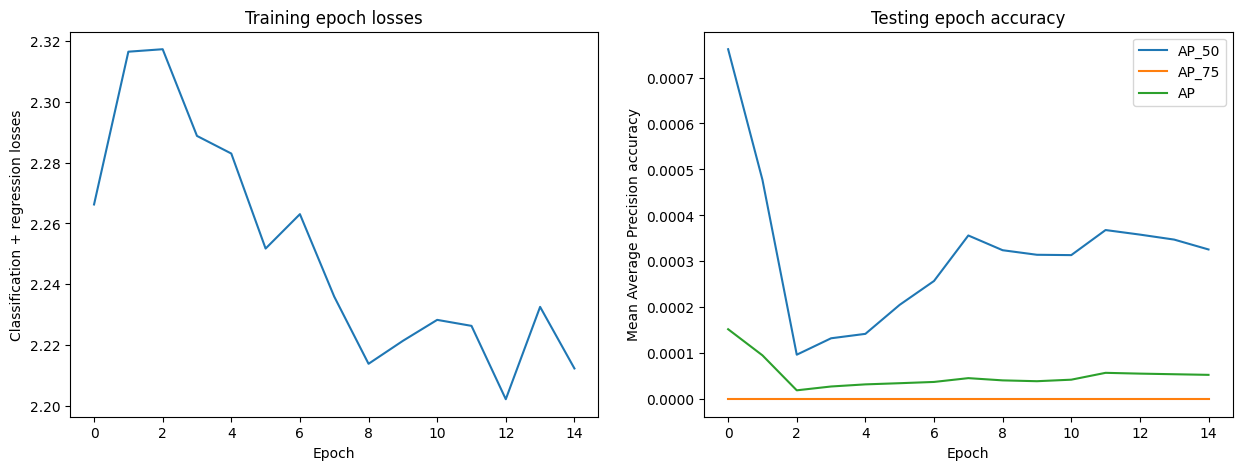

In [ ]:
train_losses = [2.2662618761569, 2.3165839193141564, 2.3173986610058135, 2.288841608351311, 2.283040010823613, 2.251741373433476, 2.2630739106541187, 2.2359079164741313, 2.2137873573640805, 2.221338928273294, 2.2282532379690525, 2.2262803062928462, 2.2021166940705967, 2.232533798808545, 2.2122505523462213]
test_AP50 = [0.0007616145885549486, 0.000477378664072603, 9.686978592071682e-05, 0.00013262240099720657, 0.00014224046026356518, 0.00020541629055514932, 0.0002572938392404467, 0.000356310949428007, 0.0003242429520469159, 0.00031431714887730777, 0.00031358448904938996, 0.0003681443049572408, 0.0003582236240617931, 0.00034735738881863654, 0.00032586019369773567]
test_AP75 = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
test_AP = [0.0001523229293525219, 9.547574154566973e-05, 1.9373961549717933e-05, 2.770643914118409e-05, 3.231254959246144e-05, 3.4864879125962034e-05, 3.7604502722388133e-05, 4.587240255204961e-05, 4.101877857465297e-05, 3.920126619050279e-05, 4.251058999216184e-05, 5.743248766520992e-05, 5.570649227593094e-05, 5.436080027720891e-05, 5.301344572217204e-05]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(train_losses)
ax1.set_title('Training epoch losses')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Classification + regression loss')
ax2.plot(test_AP50, label="AP_50")
ax2.plot(test_AP75, label="AP_75")
ax2.plot(test_AP, label="AP")
ax2.set_title('Testing epoch accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean Average Precision accuracy')
plt.legend()
plt.show()

#11.&nbsp;Conclusion
After attempting to reproduce this paper we would like to use this section to give our opinion on the experience. We found this paper surprisingly hard to reproduce and it took a lot more time and effort than expected. The main reason for this was the lack of reference code or implementation details, there were many points where we had to improvise or assume what methods they had used to achieve the given results in the paper. Nonetheless, we still managed to get all the main implementations done, even though many details were missing. The only limitation that holds us back from reproducing the last row in Table 1 of the paper is the resources to run that much data fast enough. Still, it was a very great learning experience to build up a model from an incomplete description, use an existing model, process images and targets, and write a train and test loop ourselves. 

# 12.&nbsp;Problems

In this section, we will cover a general overview of the problems and obstacles we found while attempting to complete this project.

One of the first problems we had during the reproduction was the fact that the dataset is extremely large. We decided to use a subset of 50 images, however, we felt that this might too small of a dataset, so we attempted to use image augmentation to generate more samples without having to unzip a large number of images. This lack of hardware became a recurring problem in this reproduction, for example, we attempted to use a dataset of 750 images but that required too much RAM so it caused the Google Colab execution to crash.

In the beginning, we decided to follow the lab's structure, where they are using a dataset from the torchvision datasets. Additionally to feed the networks with the data they were using Dataloaders. The torchvision datasets are built in a format that is suitable to feed the Dataloaders, as they inherit from the Dataset class and they have the structure expected which is the __getitem__ and __len__ functions in the class. The dataset that we had to use on the other side to reproduce the paper is a custom dataset with RAW images and separately obtained annotations JSON file.

Before that, we decided to use the COCO format for the dataset. The COCO format needs the images and the labels in a specific file structure and they use internal processing functions to make it suitable for Dataloader, this however proved unfruitful. The fact that we only had a subset of the images was a big obstacle. That is because we would need to modify the annotations JSON file to contain only the images that we have which was again complicated as the JSON file, except for the annotations key, contains several other key-value pairs that are important for the COCO dataset. In the end, we created a custom Dataset in a suitable form to feed into the Dataloader. This was the correct decision we should have chosen from the start as it had better support and allowed for the automatic creation of batches.

Finally, we tried to use a function to determine the mean average precision, but the results for it were not as expected. The main problem is probably the lack of enough training samples to train the model well enough in order to have a higher test accuracy.

# Who did what:

 - Alex De Los Santos Subirats: Worked on the training and testing loop as well as on the GenISP V1, the creation of the custom data set, and the preparation for execution
 
- Tsin Yu Huang: the whole preprocessing process, creating the dataset, creating the annotation dictionary, the dataloader, the training loop, utilizing cuda as device, GenISP V2, Average Precision loss

- Eleni Papadopoulou: Worked on the training and testing loop as well as on the GenISP V1 structure and the preparation for execution. Also tried the multiple versions of the dataset form like the annotation json file modification but it was not used at the end.